In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('ggplot') 
import calendar
import quandl
import pickle
import math
from datetime import datetime, timedelta
import re  
import psycopg2
import sys
import sqlalchemy
from sqlalchemy.sql import select, and_, or_, not_, desc, asc
from sqlalchemy import Table, Column, Integer, DateTime, String,Float, ForeignKey
from sqlalchemy.orm import sessionmaker

In [3]:
# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 10
# fig_size[1] = 10
# plt.rcParams["figure.figsize"] = fig_size

In [4]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con)

    return con, meta

CREATE TABLES 

In [5]:
con, meta = connect('postgres', '', 'robotdb')
    
tickers = Table('Ticker', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('price', Float),
    Column('volume', Float),
    Column('screen', String, primary_key = True)    
)

macd = Table('Macd', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('ema12', Float),
    Column('ema_26', Float),
    Column('macd_line', Float),
    Column('signal_line', Float),
    Column('histogram', Float),
    Column('screen', Integer, primary_key=True)
)

ema = Table('Ema', meta,
                Column('date', DateTime, primary_key=True),
                Column('coin', String, primary_key=True),
                Column('ema5', Float),
                Column('ema20', Float),
                Column('ema5_theta', Float),
                Column('ema20_theta', Float),
                Column('screen', Integer, primary_key=True)
                )

mkt_trend = Table('Market_trend', meta,
                  Column('coin', String, primary_key=True),
                  Column('date', DateTime, primary_key=True),
                  Column('screen', Integer, primary_key=True),
                  Column('dif_current', Float),
                  Column('dif_base', Float),
                  Column('d_dif', Float),
                  Column('theta_current', Float),
                  Column('theta_base', Float),
                  Column('d_theta', Float),
                  Column('max_growth', Float),
                  Column('max_loss', Float),
                  Column('max_price', Float),
                  Column('min_price', Float),
                  Column('vote', Integer)
                  )


rsi = Table('Rsi', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('rsi', Float),
    Column('screen', Integer, primary_key=True)
)

sma = Table('Sma', meta,
                Column('date', DateTime, primary_key=True),
                Column('coin', String, primary_key=True),
                Column('sma5', Float),
                Column('sma20', Float),
                Column('sma5_theta', Float),
                Column('sma20_theta', Float),
                Column('screen', Integer, primary_key=True)
                )

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

In [6]:
def get_macds(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([macd])\
            .where(and_(macd.c.coin == coin, macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
    else:
         s = select([macd])\
            .where(and_(macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
            
    rows = con.execute(s)
    macd_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not macd_df.empty:
        macd_df.columns = rows.keys()
    return macd_df

def get_tickers(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([tickers])\
            .where(and_(tickers.c.coin == coin, tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    else:
        s = select([tickers])\
            .where(and_(tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    rows = con.execute(s)
    tickers_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not tickers_df.empty:
        tickers_df.columns = rows.keys()
    return tickers_df

def get_emas(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([ema])\
            .where(and_(ema.c.coin == coin, ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    else:
        s = select([ema])\
            .where(and_(ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    rows = con.execute(s)
    ema_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not ema_df.empty:
        ema_df.columns = rows.keys()
    return ema_df

def get_mkt_trend(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.coin == coin, mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    else:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    return mkt_trend_df

def get_rsis(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([rsi]) \
            .where(and_(rsi.c.coin == coin,
                        rsi.c.date <= date,
                       rsi.c.screen == screen))\
            .order_by(desc(rsi.c.date))
    else:
        s = select([rsi]) \
            .where(and_(rsi.c.date <= date,
                        rsi.c.screen == screen
                       ))\
            .order_by(desc(rsi.c.date))
    rows = con.execute(s)
    rsi_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not rsi_df.empty:
        rsi_df.columns = rows.keys()
    return rsi_df

def get_smas(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([sma]) \
            .where(and_(sma.c.coin == coin,
                        sma.c.date <= date,
                       sma.c.screen == screen))\
            .order_by(desc(sma.c.date))
    else:
        s = select([sma]) \
            .where(and_(sma.c.date <= date,
                        sma.c.screen == screen
                       ))\
            .order_by(desc(sma.c.date))
    rows = con.execute(s)
    sma_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not sma_df.empty:
        sma_df.columns = rows.keys()
    return sma_df

In [7]:
def get_strength_index():
    tickers_df_two = get_tickers()
    for c in tickers_df_two.coin.unique():
        tickers_df_two_c = tickers_df_two[tickers_df_two['coin'] == c]
        print(c)
        # 6 * 4h = 24h
        delta_t = 1
        si_np = [np.nan]
        for index in range(len(tickers_df_two_c)):
            base_price = tickers_df_two_c.iloc[index].price
            if index >= (len(tickers_df_two_c)-delta_t):
                break
            current_price = tickers_df_two_c.iloc[index+1].price
            volume = tickers_df_two_c.iloc[index+1].volume
            si = (current_price - base_price) * volume
            si_np.append(si)
        tickers_df_two_c['strength'] = si_np
    return tickers_df_two_c.dropna().drop(['price', 'volume', 'screen'], axis=1)

In [8]:
def show_result(Y_test, Y_predict):
    FP, TP, thresholds = roc_curve(Y_test,Y_predict)
    roc_auc = auc(FP, TP)
    print ('ROC_AUC %s' % float(roc_auc))
    cm = confusion_matrix(Y_test,Y_predict)
    print('Confusion Matrix')
    print(cm)
    print('precision %s' % str(round((cm[1,1]/(cm[1,1]+cm[0,1])), 2)*100))
    plt.hist(Y_predict, bins=2)
    print('Unbalanced Dataset %s' % str(np.sum(Y_predict)/len(Y_predict)))
    plt.show()

FETCH DATA FROM DATABASE AND JOIN TABLES 
MKTTREND - PRICE - MACDS - RSI - SMA

In [9]:
def manipulate_mkt_data():
    #Market Trend
    mkt_trend_df = get_mkt_trend()
    #Prices
    tickers_df_two = get_tickers()
    #MACD
    macds_df = get_macds()
    
    #Merge prices and macds
    tickers_df = pd.merge(tickers_df_two, macds_df, how='inner', left_on=['date', 'coin', 'screen'],
                          right_on=['date', 'coin', 'screen'])
    #Calculate relationship between Price and EMA
    tickers_df['ema_dif'] = np.log(tickers_df['price']/tickers_df['ema12'])
    #Merge Prices and MKT TREND
    df = pd.merge(mkt_trend_df, tickers_df, how='inner', left_on=['date', 'coin', 'screen'],
                  right_on=['date', 'coin', 'screen'])
    #RSI
    rsis_df = get_rsis()
    df = pd.merge(df, rsis_df, how='inner', left_on=['date', 'coin', 'screen'],
                  right_on=['date', 'coin', 'screen'])
    #SMA
    sma_df = get_smas()
    df = pd.merge(df, sma_df, how='inner', left_on=['date', 'coin', 'screen'],
                  right_on=['date', 'coin', 'screen'])
    
    return df
    
df = manipulate_mkt_data()
df.head()

,coin,date,screen,dif_current,dif_base,d_dif,theta_current,theta_base,d_theta,max_growth,...,ema_26,macd_line,signal_line,histogram,ema_dif,rsi,sma5,sma20,sma5_theta,sma20_theta
0,USDT_BTC,2017-05-26 12:30:00,1,37.281728,50.050379,-0.255116,-1.253658,-1.235941,0.014335,0.033015,...,2333.853745,37.281728,69.076431,-31.794703,-0.033072,36.207856,2322.60,2336.206581,-87.982038,None
1,USDT_BTC,2017-05-26 16:30:00,1,-7.947962,37.281728,-1.213187,-1.250350,-1.238920,0.009226,0.118181,...,2303.708384,-7.947962,61.235443,-69.183406,-0.161697,32.157387,2273.20,2326.256581,-88.061316,None
2,USDT_BTC,2017-05-26 20:30:00,1,-23.295973,-7.947962,1.931062,-1.240125,-1.231704,0.006837,0.015202,...,2292.920375,-23.295973,44.218569,-67.514542,-0.049090,38.994601,2237.98,2323.701581,-88.133619,None
3,USDT_BTC,2017-05-27 00:30:00,1,-48.076694,-23.295973,1.063734,-1.227758,-1.223206,0.003721,0.029142,...,2271.366103,-48.076694,26.667137,-74.743831,-0.091445,38.913037,2178.78,2314.151581,-88.281161,None
4,USDT_BTC,2017-05-27 04:30:00,1,-80.453673,-48.076694,0.673444,-1.212126,-1.212147,-0.000017,0.098647,...,2243.563873,-80.453673,6.592221,-87.045894,-0.119222,37.186650,2071.38,2298.156581,-88.846952,None


CALCULATE LAGS FOR DIF_CURRENT AND THETA CURRENT

In [10]:
full_data_set = df.drop(['sma20_theta', 'screen'], axis=1)
dates_ = full_data_set[['date']]
shifted_parms = full_data_set[['coin', 'dif_current', 'theta_current']].shift(2)
shifted_parms['date'] = dates_
full_data_set = pd.merge(full_data_set, shifted_parms, how='inner', left_on=['date', 'coin'],
                         right_on=['date', 'coin'])
full_data_set['dif_current'] = full_data_set['dif_current_x']
full_data_set['theta_current'] = full_data_set['theta_current_x']
full_data_set['dif_base_p'] = full_data_set['dif_current_y']
full_data_set['theta_base_p'] = full_data_set['theta_current_y']
full_data_set = full_data_set.drop(['dif_current_x', 'dif_current_y',
                                    'theta_current_x', 'theta_current_y'], axis=1)
full_data_set['dif_sma'] = full_data_set['sma5'] - full_data_set['sma20']

FULL DATA SET JOIN STRENGTH INDEX

In [11]:
df_model = pd.merge(full_data_set, get_strength_index(), how='inner',
                    left_on=['date', 'coin'], right_on=['date', 'coin'])
df_model.columns
# df_model['strength'] = StandardScaler().fit_transform(df_model['strength'].values.reshape(-1,1))
# df_model['rsi'] = StandardScaler().fit_transform(df_model['rsi'].values.reshape(-1,1))

USDT_BTC


Index(['coin', 'date', 'dif_base', 'd_dif', 'theta_base', 'd_theta',
       'max_growth', 'max_loss', 'max_price', 'min_price', 'vote', 'price',
       'volume', 'ema12', 'ema_26', 'macd_line', 'signal_line', 'histogram',
       'ema_dif', 'rsi', 'sma5', 'sma20', 'sma5_theta', 'dif_current',
       'theta_current', 'dif_base_p', 'theta_base_p', 'dif_sma', 'strength'],
      dtype='object')

In [12]:
df_model = df_model.sort_values(['date'])
df_model.head()

,coin,date,dif_base,d_dif,theta_base,d_theta,max_growth,max_loss,max_price,min_price,...,rsi,sma5,sma20,sma5_theta,dif_current,theta_current,dif_base_p,theta_base_p,dif_sma,strength
0,USDT_BTC,2017-05-26 20:30:00,-7.947962,1.931062,-1.231704,0.006837,0.015202,-0.323278,2480.512576,1953.0,...,38.994601,2237.98,2323.701581,-88.133619,-23.295973,-1.240125,37.281728,-1.253658,-85.721581,4.048076e+09
1,USDT_BTC,2017-05-27 00:30:00,-23.295973,1.063734,-1.223206,0.003721,0.029142,-0.260296,2480.512576,1953.0,...,38.913037,2178.78,2314.151581,-88.281161,-48.076694,-1.227758,-7.947962,-1.250350,-135.371581,-1.143873e+09
2,USDT_BTC,2017-05-27 04:30:00,-48.076694,0.673444,-1.212147,-0.000017,0.098647,-0.205079,2480.512576,1817.0,...,37.186650,2071.38,2298.156581,-88.846952,-80.453673,-1.212126,-23.295973,-1.240125,-226.776581,-2.390493e+09
3,USDT_BTC,2017-05-27 08:30:00,-80.453673,0.506053,-1.198794,-0.005097,0.213541,0.000000,2458.040604,1564.0,...,39.851034,1965.78,2271.948761,-89.197186,-121.167530,-1.192684,-48.076694,-1.227758,-306.168761,-3.983082e+09
4,USDT_BTC,2017-05-27 12:30:00,-121.167530,0.136529,-1.174342,-0.008014,0.125308,-0.028181,2371.000000,1564.0,...,43.237238,1960.96,2254.331061,-89.082583,-137.710377,-1.164931,-80.453673,-1.212126,-293.371061,2.474517e+09


CALCULATE MOVING AVERAGES FOR THETA DIF AND STRENGTH

In [13]:
df_model['theta_ema'] = df_model.theta_current.ewm(span=6,min_periods=6,adjust=True,ignore_na=False).mean()
df_model['dif_ema'] = df_model.dif_current.ewm(span=6,min_periods=6,adjust=True,ignore_na=False).mean()
df_model['strength_ema'] = df_model.strength.ewm(span=6,min_periods=6,adjust=True,ignore_na=False).mean()
df_model = df_model.dropna()
len(df_model)

1787

SET CLASSES: | 1 -> MAX GROWTH >= TRESHOLD
             | 0 -> MAX GROWTH < TRESHOLD
SET CLASSES: | 1 -> MIN GROWTH <= TRESHOLD
             | 0 -> MIN GROWTH > TRESHOLD

In [14]:
df_model.loc[df_model['max_growth'] >= 0.1, 'growth_sign'] = 1
df_model.loc[df_model['max_growth'] < 0.1, 'growth_sign'] = 0
df_model.loc[df_model['max_loss'] <= -0.05, 'loss_sign'] = 1
df_model.loc[df_model['max_loss'] > -0.05, 'loss_sign'] = 0

In [15]:
df_model.columns

Index(['coin', 'date', 'dif_base', 'd_dif', 'theta_base', 'd_theta',
       'max_growth', 'max_loss', 'max_price', 'min_price', 'vote', 'price',
       'volume', 'ema12', 'ema_26', 'macd_line', 'signal_line', 'histogram',
       'ema_dif', 'rsi', 'sma5', 'sma20', 'sma5_theta', 'dif_current',
       'theta_current', 'dif_base_p', 'theta_base_p', 'dif_sma', 'strength',
       'theta_ema', 'dif_ema', 'strength_ema', 'growth_sign', 'loss_sign'],
      dtype='object')

CALCULATE LAG FOR MAX LOSS AND MAX GROWTH

In [16]:
dates_ = df_model[['date']]
shifted_parms = df_model[['coin', 'max_growth', 'max_loss']].shift(1)
shifted_parms['date'] = dates_
df_model = pd.merge(df_model, shifted_parms, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
df_model.head()
df_model['max_growth'] = df_model['max_growth_x']
df_model['max_loss'] = df_model['max_loss_x']
df_model['max_growth_p'] = df_model['max_growth_y']
df_model['max_loss_p'] = df_model['max_loss_y']
df_model = df_model.drop(['max_growth_x', 'max_growth_y', 'max_loss_x', 'max_loss_y'], axis=1)
df_model.head()

,coin,date,dif_base,d_dif,theta_base,d_theta,max_price,min_price,vote,price,...,strength,theta_ema,dif_ema,strength_ema,growth_sign,loss_sign,max_growth,max_loss,max_growth_p,max_loss_p
0,USDT_BTC,2017-05-27 20:30:00,-133.912608,-0.003396,-1.107985,-0.007614,2194.000000,1564.0,0,1952.20,...,-6.613904e+08,-1.150813,-118.846656,-1.147207e+08,1.0,0.0,0.113301,-0.040188,0.078171,-0.075318
1,USDT_BTC,2017-05-28 00:30:00,-133.457811,-0.084798,-1.067307,-0.001086,2089.000000,1564.0,0,2089.00,...,1.035569e+09,-1.124865,-119.856287,2.378221e+08,0.0,1.0,0.045572,-0.107917,0.113301,-0.040188
2,USDT_BTC,2017-05-28 04:30:00,-122.140918,-0.094081,-1.029493,0.010101,2119.059000,1564.0,0,2099.00,...,8.536187e+07,-1.099352,-117.092070,1.920465e+08,0.0,1.0,0.040797,-0.112692,0.045572,-0.107917
3,USDT_BTC,2017-05-28 08:30:00,-110.649790,-0.097598,-0.998318,0.025716,2186.402801,1766.0,0,2134.43,...,3.288453e+08,-1.077049,-111.989534,2.325315e+08,0.0,1.0,0.014982,-0.129431,0.040797,-0.112692
4,USDT_BTC,2017-05-28 12:30:00,-99.850602,0.061095,-0.990019,0.034601,2186.402801,1875.3,0,1926.00,...,-2.648631e+09,-1.061589,-110.220536,-6.115003e+08,1.0,0.0,0.107694,-0.013591,0.014982,-0.129431


REMOVE MISSING DATA AND OUTLIERS

In [17]:
df_model = df_model[~(np.abs(df_model.d_dif-df.d_dif.mean())>(3*df_model.d_dif.std()))]
df_model = df_model[~(np.abs(df_model.strength_ema-df_model.strength_ema.mean())>(3*df_model.strength_ema.std()))]
df_model = df_model[~(np.abs(df_model.d_theta-df.d_theta.mean())>(3*df_model.d_theta.std()))]
print(len(df_model))
df_model = df_model.dropna()
df_model = df_model.sort_values(['date'])
df_model = df_model.drop(['coin', 'date', 'vote'], axis=1)

1729


In [18]:
df_model.columns

Index(['dif_base', 'd_dif', 'theta_base', 'd_theta', 'max_price', 'min_price',
       'price', 'volume', 'ema12', 'ema_26', 'macd_line', 'signal_line',
       'histogram', 'ema_dif', 'rsi', 'sma5', 'sma20', 'sma5_theta',
       'dif_current', 'theta_current', 'dif_base_p', 'theta_base_p', 'dif_sma',
       'strength', 'theta_ema', 'dif_ema', 'strength_ema', 'growth_sign',
       'loss_sign', 'max_growth', 'max_loss', 'max_growth_p', 'max_loss_p'],
      dtype='object')

Unbalanced Dataset 0.08733371891266628


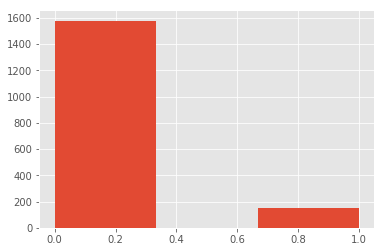

In [19]:
plt.hist(df_model['growth_sign'], bins=3)
print('Unbalanced Dataset %s' % str(np.sum(df_model['growth_sign'])/len(df_model)))
plt.show()

Unbalanced Dataset 0.33314054366685947


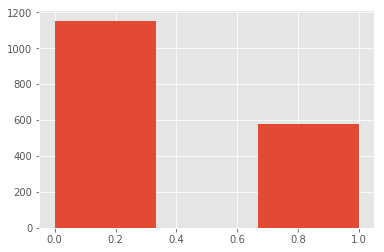

In [20]:
plt.hist(df_model['loss_sign'], bins=3)
print('Unbalanced Dataset %s' % str(np.sum(df_model['loss_sign'])/len(df_model)))
plt.show()

In [28]:
train = df_model.iloc[:math.floor(len(df_model)*0.75)]
test = df_model.iloc[math.floor(len(df_model)*0.75):len(df_model)]

0

Unbalanced Dataset 0.08641975308641975


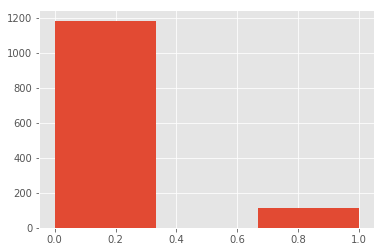

Unbalanced Dataset 0.09006928406466513


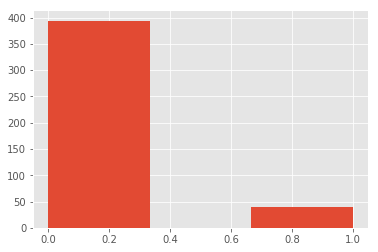

In [29]:
plt.hist(train['growth_sign'], bins=3)
print('Unbalanced Dataset %s' % str(np.sum(train['growth_sign'])/len(train)))
plt.show()
plt.hist(test['growth_sign'], bins=3)
print('Unbalanced Dataset %s' % str(np.sum(test['growth_sign'])/len(test)))
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

features = df_model.drop(['growth_sign','loss_sign', 'max_loss', 'max_growth',
                         'd_theta', 'rsi', 'max_loss_p', 'd_dif'] ,axis=1)
features[features.columns] = MinMaxScaler().fit_transform(features)

features.head()
# for c in features.columns:
#     print(c)
#     df_model.groupby("growth_sign")[c].plot(kind='kde')
#     plt.show()

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size

correlations = features.corr()
names = features.columns
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(names),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df.to_pickle("historical_mkt.pkl")

In [ ]:
df_model = pd.read_pickle("historical_mkt.pkl")
df_model.head()

In [ ]:
df_model.describe()

In [ ]:
X, y = df_model[['max_growth_p', 'dif_ema', 'theta_ema', 'strength_ema','ema_dif']], df['growth_sign']
X.head()

In [ ]:
y.head()

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(X)
# pca.components_
# principalDf = pd.DataFrame(data = principalComponents, columns = ['VC1',
#                                                                   'VC2'])
# finalDf = pd.concat([principalDf, y], axis = 1)
# df_model = finalDf
# X = df_model.drop(['growth_sign'], axis=1)
# y = df_model['growth_sign']

In [ ]:
# finalDf.groupby("growth_sign").VC1.plot(kind='kde')
# plt.show()
# finalDf.groupby("growth_sign").VC2.plot(kind='kde')
# plt.show()
# finalDf.groupby("growth_sign").VC3.plot(kind='kde')
# plt.show()